In [1]:
from tokenizers import Tokenizer
from fourm.vq.vqvae import VQVAE, DiVAE
import os
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io
import cv2
from IPython.display import display, clear_output
import time
from skimage.metrics import structural_similarity as ssim

import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from fourm.data.modality_transforms import RGBTransform
from fourm.utils import denormalize, IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD, IMAGENET_DEFAULT_STD, IMAGENET_DEFAULT_MEAN
# The flag below controls whether to allow TF32 on matmul. This flag defaults to False in PyTorch 1.12 and later.
torch.backends.cuda.matmul.allow_tf32 = True
# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_grad_enabled(False)

/home/skalli/.local/lib/python3.10/site-packages/fourm/vq/quantizers/quantize_lucid.py:263: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/home/skalli/.local/lib/python3.10/site-packages/fourm/vq/quantizers/quantize_lucid.py:388: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


xFormers not available
xFormers not available


In [33]:
from huggingface_hub import snapshot_download
from cosmos_tokenizer.image_lib import ImageTokenizer
snapshot_download(
    repo_id='nvidia/Cosmos-0.1-Tokenizer-DI16x16', 
    local_dir='/tmp/nvidiaxxxx/Cosmos-0.1-Tokenizer-DI16x16'
)
image_tokenizer = ImageTokenizer(
    checkpoint_enc='/tmp/nvidiaxxxx/Cosmos-0.1-Tokenizer-DI16x16/encoder.jit',
    checkpoint_dec='/tmp/nvidiaxxxx/Cosmos-0.1-Tokenizer-DI16x16/decoder.jit',
).to(device)

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

In [32]:
img = Image.open('penn_action_raw/Penn_Action/frames/0001/000008.jpg').resize((640,640))
img_tensor = TF.to_tensor(img).to(device).unsqueeze(0) * 2 - 1
print(img_tensor.shape)
img
# ------------- helpers -----------------
def encode_rgb(img: Image.Image) -> np.ndarray:
    ten = TF.to_tensor(img).unsqueeze(0).to(device) * 2 - 1
    with torch.inference_mode():
        tok, _ = image_tokenizer.encode(ten)
    return tok.squeeze(0).cpu().short().numpy()
    

torch.Size([1, 3, 640, 640])


In [37]:
tokens, _ = image_tokenizer.encode(img_tensor)

# Ensure tokens is on CPU and convert it to a NumPy array
tokens = tokens.cpu().numpy()

# Check if there are any negative values in the tokens
if np.any(tokens < 0):
    print("There are negative values in the tokens!")
    print(tokens[tokens < 0])  # This will print the negative values
else:
    print("No negative values in the tokens.")

print(tokens.shape)
print(tokens)
img = Image.open('penn_action_raw/Penn_Action/frames/0001/000008.jpg').resize((640,640))
tokens_neg = encode_rgb(img)

# Ensure tokens is on CPU and convert it to a NumPy array

# Check if there are any negative values in the tokens
if np.any(tokens_neg < 0):
    print("There are negative values in the tokens!")
    print(tokens_neg[tokens_neg < 0])  # This will print the negative values
else:
    print("No negative values in the tokens.")

print(tokens_neg.shape)
print(tokens_neg)


No negative values in the tokens.
(1, 40, 40)
[[[35627 40711 22809 ... 58253 58661 41885]
  [49060 44375 10630 ... 22755 17230 17038]
  [ 1485 58650 25038 ... 19295 23398 18863]
  ...
  [13704 38304 27371 ... 48432 17361 45400]
  [30025 45929 33168 ... 27480 35656 41376]
  [22376 55232 21856 ... 45400 14240 30617]]]
There are negative values in the tokens!
[-29909 -24825  -8795  -2020 -11451  -5628 -32501 -14492 -22074  -9436
 -17467  -7758  -9913 -17118  -4140  -4381 -22060  -5241  -5756 -23706
 -13728  -1932 -16914  -4284 -11817  -5243 -19477  -7283  -6875 -23651
 -16476 -21161 -25732 -17309 -22073 -32563 -14460 -30810 -22364 -22174
 -18617 -17577 -18554 -17019 -20201  -9916 -19547  -6886 -24629 -10149
 -17181  -9276 -30426  -3244  -1757 -14422 -16266  -6161 -28420 -28810
 -28753 -21198 -24697  -4202 -21599 -22254 -17077 -30915 -21619 -12043
 -29849 -21658 -31308  -9443  -5778 -19506 -32348 -23060 -14704  -9331
 -26367 -23065 -26705 -23628 -31265 -20002 -22091 -11922 -25174 -23074
 -

In [ ]:
reconst = image_tokenizer.decode(tokens).float().clamp(-1,1)
reconst.shape

In [ ]:
img = Image.open('penn_action_raw/Penn_Action/frames/0088/000001.jpg').resize((640,640))
img_tensor = TF.to_tensor(img).to(device).unsqueeze(0) * 2 - 1
tokens, _ = image_tokenizer.encode(img_tensor)
print(tokens.shape)
print(tokens)
reconst = image_tokenizer.decode(tokens).float().clamp(-1,1)
reconst.shape
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].imshow(img)
ax[0].set_title('Original RGB')
ax[1].imshow(reconst[0].cpu().permute(1,2,0) / 2 + 0.5)
ax[1].set_title('Cosmos tokenizer reconstruction')
plt.show()

No negative values found in any tok_rgb file.
[[[29988 40647 33050 ... 58708 61284 54677]
  [31207 57677  8079 ... 35429 30030 14997]
  [22816 40407 37837 ... 34223 23399 21423]
  ...
  [26441 25000 40163 ... 45992 30089 42848]
  [30089 58721 32720 ... 45832 21920 41809]
  [24936 42944 13648 ... 29657 53536 29594]]]


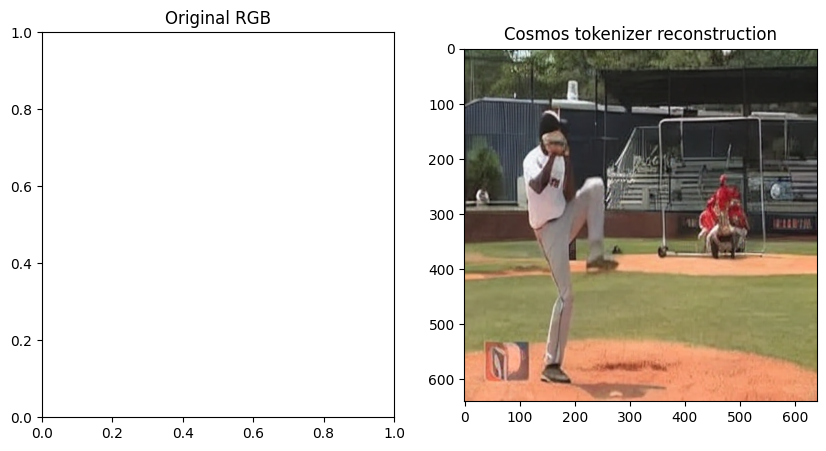

In [54]:
import numpy as np
import os
from nanofm.data.multimodal.penn_action_multimodal_dataset import (
    PennActionMultimodalDataset
)
import numpy as np
import os

# Define the path to the tok_rgb directory
root_dir = "/work/com-304/CFT/output/train"  # Update this path if needed
split = "train"  # Change this to 'val' or 'test' if needed
video_id = "0094"  # For example, the first video
modality = "tok_rgb"

# Path to the directory containing tok_rgb files for video 0001
tok_rgb_dir = "../project/output/tok_rgb/0001/"

# List all .npy files in the directory
npy_files = [f for f in os.listdir(tok_rgb_dir) if f.endswith('.npy')]

# Check all npy files for negative values
negative_found = False
for npy_file in npy_files:
    # Load the npy file
    tok_rgb_data = np.load(os.path.join(tok_rgb_dir, npy_file))
    
    # Check if there are any negative values in the data
    if np.any(tok_rgb_data < 0):
        negative_found = True
        print(f"Negative values found in {npy_file}!")
        print(tok_rgb_data[tok_rgb_data < 0])  # Print the negative values

# If no negative values were found, print this
if not negative_found:
    print("No negative values found in any tok_rgb file.")
print(tok_rgb_data)
tok_rgb_data=torch.from_numpy(tok_rgb_data).to(device) 
reconst = image_tokenizer.decode(tok_rgb_data).float().clamp(-1,1)
reconst.shape
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].set_title('Original RGB')
ax[1].imshow(reconst[0].cpu().permute(1,2,0) / 2 + 0.5)
ax[1].set_title('Cosmos tokenizer reconstruction')
plt.show()